# BM 336546 - HW1: Fetal Cardiotocograms 
# Part I: Data Exploration

In this homework you will be working on predicting fetal outcomes from continuous labor monitoring using Cardiotography (CTG). In particular you will use measures of the fetal heart rate (FHR) and use these as input features to your linear classifier. Before we dive into the assignment itself, let's make a quick introduction to CTG and get familiar with this type of examination and its underlying physiological basis as a good biomedical engineer!

Intrapartum CTG is used routinely to measure maternal uterine pressure and fetal heart rate (FHR). Antepartum CTG monitoring is used to identify fetuses at risk of intrauterine hypoxia and acidaemia. As early as 28 weeks of gestation, analysis of the FHR trace is used as a nonstress test to assess the fetal well-being. In the perinatal period, timely, appropriate intervention can avoid fetal neurological damage or death. The CTG is visually assessed by a clinician or interpreted by computer analysis. In the context of labor monitoring, the CTG is used for continuous fetal monitoring. An abnormal heart rate will lead the clinician to perform a cesarean. We will focus on CTG monitoring during labor in this assignment.

The CTG has two different transducers: One of them is a transducer placed on the mother’s abdomen, above the fetal heart, to monitor heart rate using Doppler probe (cardiogram). The other is located at the fundus of the uterus to measure frequency of contractions (tocogram). Tocodynamometry is a strain gauge technology provides contraction frequency and approximate duration of labor contractions.

We can extract a lot of features from a CTG. Here are some of them:
* **Uterine activity**: Duration, frequency and intensity of contractions.
* **Baseline FHR**: Mean FHR rounded to increments of 5 beats per minute (bpm) during a 10-minute window.
* **Baseline FHR variability**: Fluctuations in the baseline FHR that are irregular in amplitude and frequency.
* **Presence of accelerations**: A visually apparent abrupt increase in fetal heart rate.

Here is an example of a typical CTG with some of its features:

![img](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/6ed5ef1da100ebc2241c3a3945e1da9ce79f73ac/1-Figure1-1.png)

TThe CTG dataset is an Excel file which was sent to you. For more information, please look at the Excel sheet called Description or take a look at this [link](http://archive.ics.uci.edu/ml/datasets/Cardiotocography). Our main goal in this assignment is to train an algorithm to decide what is the fetal state according to the extracted features. Before we even start dealing with the data itself, we should apply the first and most important rule of data/signal processing: **ALWAYS LOOK AND UNDERSTAND THE DATA FIRST!**

In order to do that, we will load the file into a variable called CTG_features and use descriptive statistics and visualization tools you have seen in the lectures.


In [4]:
import pandas as pd 
import numpy as np
from pathlib import Path

file = Path.cwd().joinpath('messed_CTG.xls') # concatenates messed_CTG.xls to the current folder that should be the extracted zip folder 
CTG_dataset = pd.read_excel(file, sheet_name='Raw Data')
CTG_features = CTG_dataset[['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DR', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency']]
CTG_morph = CTG_dataset[['CLASS']]
fetal_state = CTG_dataset[['NSP']]

First  look at the data in your Excel file. You can see that in some of the cells we have '--' or NaN etc. Furthermore, the description tells us that the feature `DR` was removed although we did load it into our dataset. Your first job is: Implement the function `rm_ext_and_nan` in the module  `clean_data` so it will remove the extra feature `DR` (ignore the feature), and all non-numeric values (ignore the samples). This function should return a dictionary of features where the values of each feature are the clean excel columns without the `DR` feature. **Hint**: In order to eliminate every cell that is non-numeric, you will have to transform it first to NaN and only then eliminate them. **Note**: `CTG_dataset` is a `pandas DataFrame` and every element within it is called `pandas series`. For our use, you can treat a dataframe as if it were a dictionary so that every key has a pandas series as value. **Bonus**:  Implement the function in a single line of code using dictionary comprehensions.

In [5]:
from clean_data import rm_ext_and_nan as rm
extra_feature = 'DR' 
c_ctg = rm(CTG_features, extra_feature)

NameError: name 'c_ctg' is not defined

Compare and make sure that your function works well: let's compare the histograms' width feature . First we will plot the original distribution of this feature where every NaN element was replace by a value that is not reasonable as 1000 :

In [3]:
import matplotlib.pyplot as plt
feat = 'Width'
Q = pd.DataFrame(CTG_features[feat])
idx_na = Q.index[Q[feat].isna() == True].tolist()
for i in idx_na:
    Q.loc[i] = 1000
Q.hist(bins = 100)
plt.xlabel('Histogram Width')
plt.ylabel('Count')
plt.show()

<Figure size 640x480 with 1 Axes>

Now run the following lines of code to check how you performed:

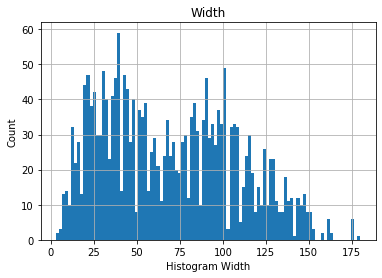

In [4]:
feat = 'Width'
Q_clean = pd.DataFrame(c_ctg[feat])
Q_clean.hist(bins=100)
plt.xlabel('Histogram Width')
plt.ylabel('Count')
plt.show()

Now that we are warmed up, let's do something a bit different. Instead of removing the NaN values, handle those missing values using sampling (**Lecture 2, slide 33**). Again, first convert all non-numeric values to NaN and only then apply the sampling method. Implement the function `nan2num_cdf`. Don't forget to remove `DR` again.

In [5]:
from clean_data import nan2num_cdf
extra_feature = 'DR' 
c_cdf = nan2num_cdf(CTG_features, extra_feature)

Now run the following lines of code to check how you performed for example with the feature `MSTV`:

In [6]:
feat = 'MSTV'
print(CTG_features[feat].iloc[0:5]) # print first 5 values
print(c_cdf[feat].iloc[0:5])

0    NaN
1     --
2     --
3    2.1
4    2.4
Name: MSTV, dtype: object
0    1.4
1    0.7
2    0.8
3    2.1
4    2.4
Name: MSTV, dtype: float64


Let's visualize our "clean" data using histograms, barplots and boxplots and then refer to the following questions below.

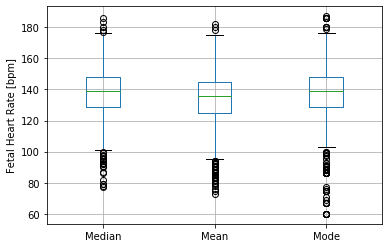

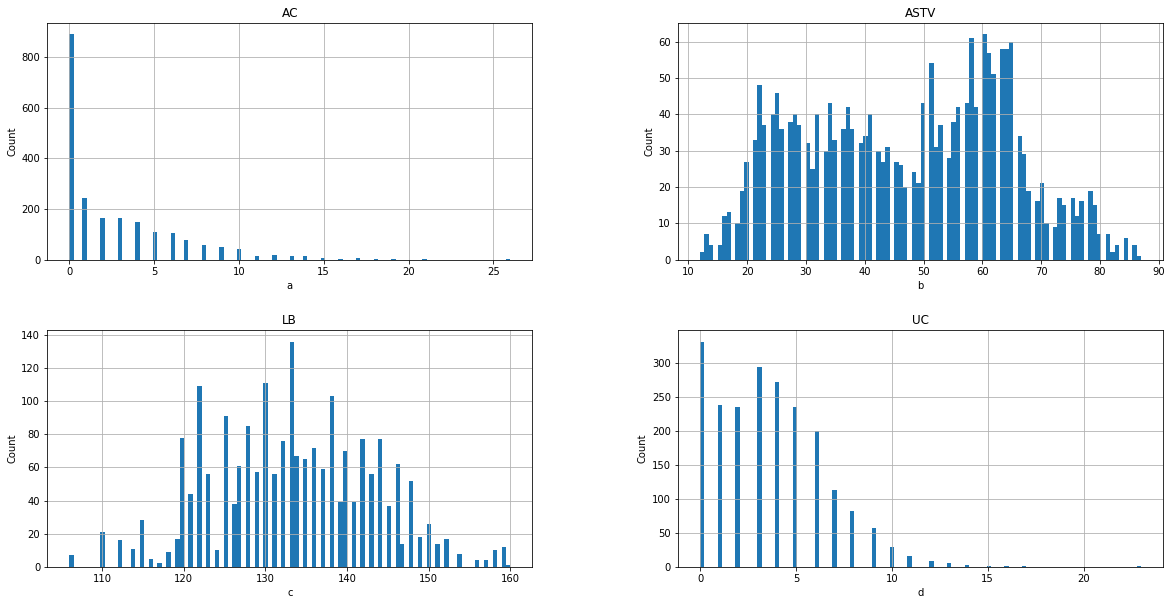

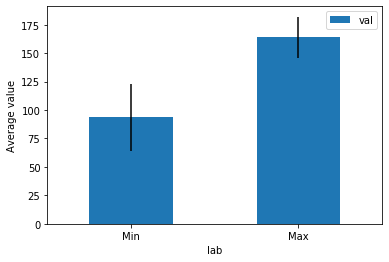

In [7]:
# Boxplots
c_cdf.boxplot(column=['Median','Mean','Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')
# Histograms
xlbl = ['beats/min','1/sec','1/sec','%']
axarr = c_cdf.hist(column=['LB', 'AC', 'UC','ASTV'], bins=100,layout = (2, 2),figsize=(20, 10))
for i,ax in enumerate(axarr.flatten()):
    ax.set_xlabel(xlbl[i])
    ax.set_ylabel("Count")
# Barplots (error bars)
df = pd.DataFrame.from_dict({'lab':['Min','Max'], 'val':[np.mean(c_cdf['Min']), np.mean(c_cdf['Max'])]})
errors = [np.std(c_cdf['Min']), np.std(c_cdf['Max'])] 
ax = df.plot.bar(x='lab', y='val', yerr=errors, rot=0)
ax.set_ylabel('Average value')
plt.show()

**Remarks**: 
* Please answer all of the following questions within the notebook itself. Remember that the only files you will submit are the notebook and the fully-implemented `.py` files.
* Do not change the notebook's cells unless you were specificly told to (such as the "Answers" cells etc.). 

### Questions:
**Q1:** What information can you get from histograms and what information can you get from boxplots?

**Q2:** Error bars can be misleading. In what sense?

### Answers:
**Q1:**


**Q2:**


Now that we have visualized  the data, cleaned it and obtained some insights from it, we would like to compute the summary statistics for each feature. Implement the `sum_stat` function which returnes a dictionary of dictionaries, meaning that a key value of a feature will return a dictionary with keys of min, Q1, median, Q3, max.
It should look something like this:

d_summary = {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"MSTV": {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"min": 2.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q1": 3.0,<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"median": 4.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q3": 5.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"max": 6.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;},<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"LB": {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"min": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q1": ...,<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"median": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q3": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"max": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;},<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;}<br>
<br> 
You can access with : d_summary["MSTV"]["min"] = 2.0

You can use that output in order to have another cleanup and this time, it will be a cleanup of outliers. We will stick to the definition of an outlier according to the five number summary that are actually represented by boxplots. Just as a reminder and comparison to a normal distribution, have a look at the next figure:




<img src="https://miro.medium.com/max/1400/1*NRlqiZGQdsIyAu0KzP7LaQ.png" width="400">

In [7]:
from clean_data import sum_stat as sst
d_summary = sst(c_cdf)
print(d_summary['MSTV'])

NameError: name 'c_cdf' is not defined

Implemet the function `rm_outlier` that will have the output of `sum_stat` as an input and will return a dictionary (similar to `c_ctg`) that will have outliers removed.

In [9]:
from clean_data import rm_outlier
c_no_outlier = rm_outlier(c_cdf, d_summary)

Let's take the features `Median`, `Mean` and `Mode` for comparioson previous to outliers removal and after it using boxplots. First we plot the original data:

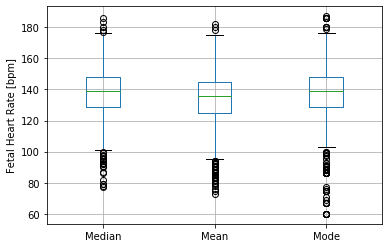

In [10]:
c_cdf.boxplot(column=['Median','Mean','Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')
plt.show()

Now we plot the "clean data":

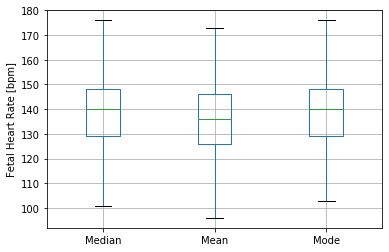

In [11]:
c_no_outlier.boxplot(column=['Median','Mean','Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')
plt.show()

### Questions:
**Q3:** Boxplotting the data after the outliers were removed shows us that there are no outliers anymore. Is it necessarily always the case, meaning if you take the "clean" data and boxplot it again will it have no outliers for sure?

### Answers:
**Q3:**

Now, there is one more thing that should be reminded in the aspect of data exploration and it is the second rule of this field that states the following: **USE COMMON SENSE!**

What it really means is that if you have some physiological prior (e.g. you know the range of values of your features), so you should have some sanity checks. For example, the feature `LB` tells us about the FHR baseline. It won't make any sense if we found values that are higher than 500 bpm, not even mentioning non-positive values. Your next mission is to implement the function `phys_prior` where you choose one feature (which is not `LB`), explain what you think it's normal range is and clean it accordingly. The function will have `c_cdf`, the feature that you chose and a threshold as inputs. The explanation should be written shortly as a comment next to the input as you can see at the following cell. The only lines you can change here is the `feature` value, the `thresh` value and its comment.

In [12]:
from clean_data import phys_prior as phpr
feature = 'LB' # change this feature
thresh = 500 # FHR cannot be more then 500 bpm. Change this threshold accordingly to the feature
filt_feature = phpr(c_cdf, feature, thresh)

## Data Scaling: Standardization and Normalization

By this point you have successfully cleaned your dataset, well done! The clean dataset was saved in pickle format called `objs.pkl`.

In [13]:
import pickle

with open('objs.pkl', 'rb') as f:
    CTG_features, CTG_morph, fetal_state = pickle.load(f)
orig_feat = CTG_features.columns.values

Now we will address an important step in data science which is called feature scaling. Here we will discuss about standardization and normalization. As you saw in the lectures, scaling enables us to prepare features that take their value in different ranges and map them to a “normalized” features that take their values in similar ranges.

Implement the function `norm_standard` that will have four inputs: `data`, `selected_feat`, `mode` and `flag`. The function will return the data normalized/standardized according to the mode. You should also choose two features for comparison (using histograms) between the original data and the different modes. Use `matplotlib` as you saw in your tutorials. The argument `flag` is used for visibility of histograms.  There are three types of `mode`: `'standard','MinMax' and 'mean'`. Look for their meanings in the third lecture, sildes 8-9. The first call uses `mode=none` and `flag=False` (as defaults). Don't change this deafult. The only variable you are allowed to change in the next cel is `selected_feat`.

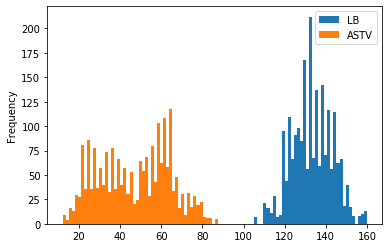

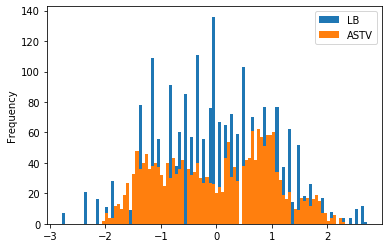

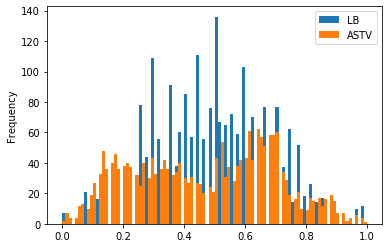

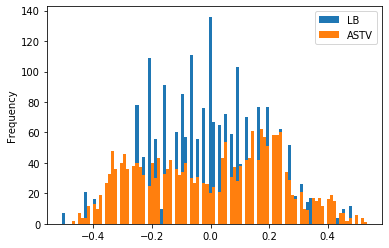

In [14]:
from clean_data import norm_standard as nsd
selected_feat = ('LB','ASTV')
orig = nsd(CTG_features,selected_feat,flag=True)
nsd_std = nsd(CTG_features,selected_feat,mode='standard',flag=True)
nsd_norm = nsd(CTG_features,selected_feat,mode='MinMax',flag=True)
nsd_norm_mean = nsd(CTG_features,selected_feat,mode='mean',flag=True)

### Questions:
**Q4:** Explain why normalization is not useful when there are outliers with extremely large or small values.

### Answers:
**Q4:** 

# Part II: Linear Classifiers

Finally, after all of the hard work we can now harvest the fruits (your functions from Part I) in order to do some proper machine learning!  

Note: It is recommended that you attend the second workshop for this part and use the notes in your homework folder.

In this assignment we will assume that our data is linearly separable and we will use logistic regression as our classification method. In other words, we choose a linear hypothesis class function . We would try to make the separation in the feature domain (i.e. our graph axes are the features) and we will have a multiclass problem.

For every sample (example as called in the lecture) we have two types of labels and we will deal only with one of them. Our goal is to learn the function that gets a sample as an input and returns a predicted value which is supposed to be the calss (label) that it belongs to. Our type of label will be `fetal_state`. Before we continue towards the "learning" part we will have another look at our data. Starting with our labels distribution.

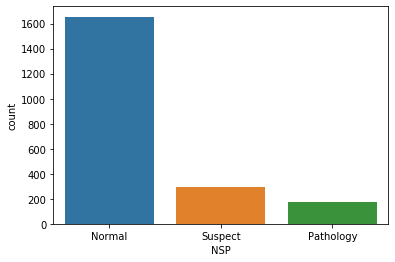

Normal samples account for 77.85% of the data.
Suspect samples account for 13.88% of the data.
Pathology samples account for 8.28% of the data.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
g = sns.countplot(x = 'NSP', data = fetal_state)
g.set(xticklabels=['Normal','Suspect','Pathology'])
plt.show()
idx_1 = (fetal_state == 1).index[(fetal_state == 1)['NSP'] == True].tolist()
idx_2 = (fetal_state == 2).index[(fetal_state == 2)['NSP'] == True].tolist()
idx_3 = (fetal_state == 3).index[(fetal_state == 3)['NSP'] == True].tolist()
print("Normal samples account for " + str("{0:.2f}".format(100*len(idx_1)/len(fetal_state))) + "% of the data.")
print("Suspect samples account for " + str("{0:.2f}".format(100*len(idx_2)/len(fetal_state))) + "% of the data.")
print("Pathology samples account for " + str("{0:.2f}".format(100*len(idx_3)/len(fetal_state))) + "% of the data.")

We can see that most of the CTG's were labeled as normal. Mostly, lables are made by professionals (in our case, doctors) based on the interpretation of the FHR and our job is to make the computer make the same decisions as a doctor would do but automatically. Now let's get the feeling of how well the features correlate with the labels and with one another. 

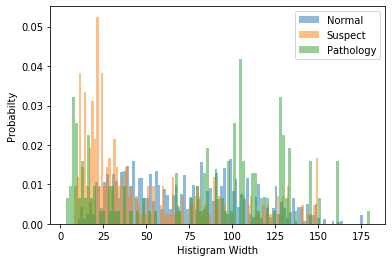

In [16]:
bins = 100
feat = 'Width'
plt.hist(CTG_features[feat].loc[idx_1], bins, density=True, alpha=0.5, label='Normal')
plt.hist(CTG_features[feat].loc[idx_2], bins, density=True, alpha=0.5, label='Suspect')
plt.hist(CTG_features[feat].loc[idx_3], bins, density=True, alpha=0.5, label='Pathology')
plt.xlabel('Histigram Width')
plt.ylabel('Probabilty')
plt.legend(loc='upper right')
plt.show()

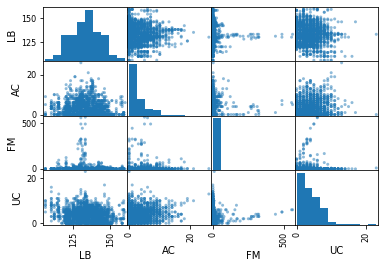

In [17]:
pd.plotting.scatter_matrix(CTG_features[['LB','AC','FM','UC']])
plt.show()

### Questions:
**Q5:** What information does feature-feature correlation provide and what feature-target (mRMR)

### Answers:
**Q5:** 

Alright, we are pretty much done with data exploration. Now the learning part begins. As you saw in the tutorials, one of the most common and useful packages that Python has to offer in the learning field is `sklearn` package. The first thing you need to do after exploring your data is to divide it into 2 sets: `training set` and `test set`. As a rule of thumb, a typical split of your dataset is 80%, 20%  respectively. Later on we will also use validation set.
One of the most common linear classification models is logistic regression – abbreviated ‘LR’. We will use this model through our assignment from now on. 
Implement the function `pred_log` which is in the module `lin_classifier`. It should return a tuple of two elements. The first one is a vector of predicted classes and the other one is the weighting matrix (w) that should have the shape of (# of classes, # of features).

As you noticed, most of our data is labeled as "Normal" which means that our data is *imbalanced*. This can cause **biased learning**. This is the reason why we *statification* when we split out data to training and test sets. Stratification means that the split preserves the percentage of samples for each class.

In [18]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lin_classifier import *
orig_feat = CTG_features.columns.values
X_train, X_test, y_train, y_test = train_test_split(CTG_features, np.ravel(fetal_state), test_size=0.2, random_state=0, stratify=np.ravel(fetal_state))
logreg = LogisticRegression(solver='saga', multi_class='multinomial', penalty='none', max_iter=10000)
y_pred, w = pred_log(logreg, X_train, y_train, X_test)
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

Accuracy is: 88.03%


Hopefully, you got about 88% accuracy. Not bad! This is a good result comparing the naive classifier (prediciting a "Normal" label for every sample) that should have given us around 77% accuracy. Now let's see if normalization and standardization help us. Fill the next cell and print the three accuracies of the standardized and normalized training and testing data. *Important notes*:

* Avoid information leakage!
* Do not apply the `norm_standard (nsd)` function on the labels. 
* Set the `flag` argument to `False` when using `nsd` function.

In [19]:
# Implement your code here:
mode = # choose a mode from the `nsd` 
y_pred, w_norm_std = pred_log(logreg,) # complete this function using nsd function
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

Accuracy is: 90.61%


You can now choose one of the training-testing dataset and stick to it. Let's visualize our learned parameters. Use your chosen weight matrix as an input to the function `w_no_p_table` in the next cell.

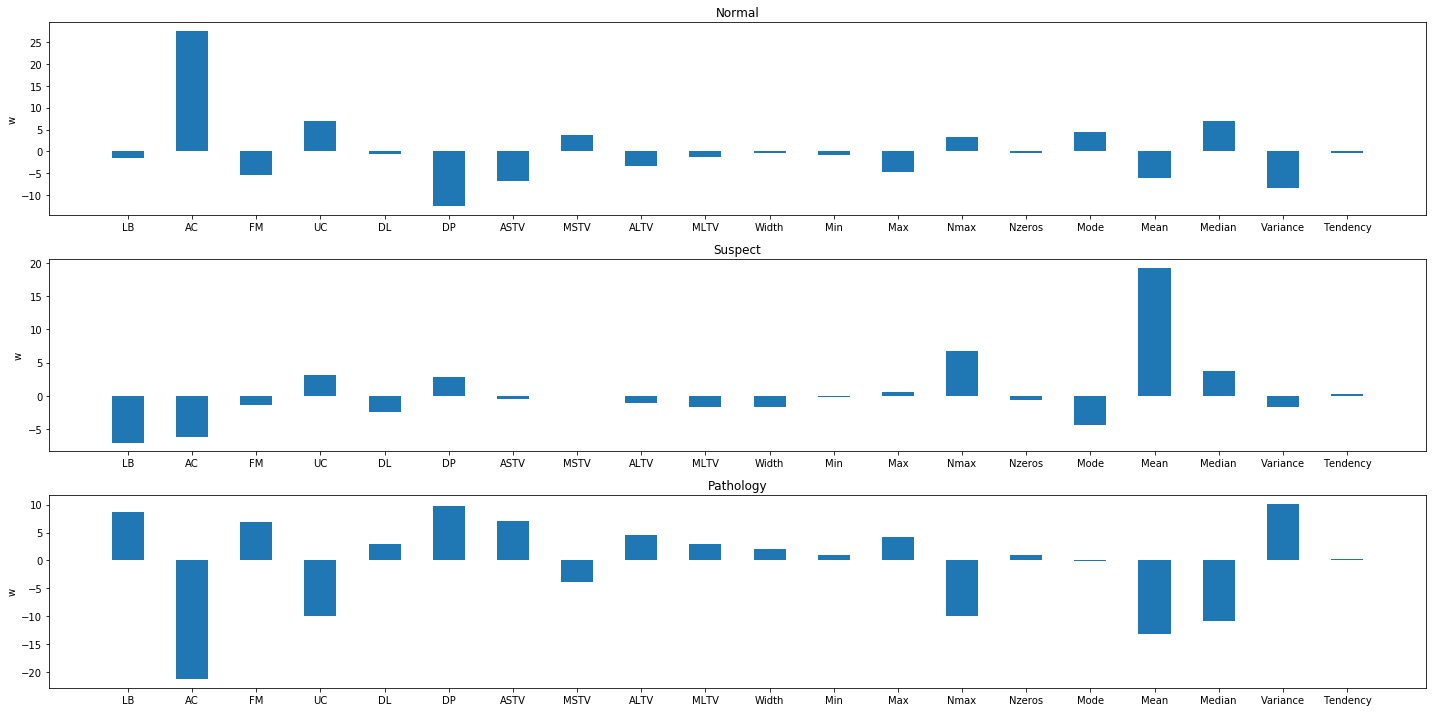

In [21]:
input_mat =  # Fill this argument
w_no_p_table(input_mat,orig_feat)

### Questions:
**Q6:** Mention one advantage and one limitation of using cross entropy.


**Q7:** By selecting one feature at a time and compare their learned weights by looking at plots we had, what can you tell about the weights relations? Why does it happen? **Hint:** notice the sign of the weights and remember that an exponent is a monotonic function.

### Answers:
**Q6:**

**Q7:**

Ok, now let's recall that in the lecture you saw that accuracy is not always our best measure. Sensitivity and specificity can be much more informative and important mostly. The choise to train a model to have better results in sensitivity aspect rather than specificty or vice versa depends on our application.

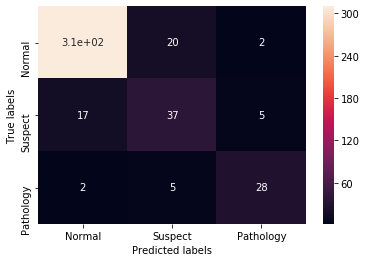

In [22]:
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
    ax.set(ylabel='True labels', xlabel='Predicted labels')
    plt.show()

### Questions:
**Q8:** What do you think is more important to us with this data? What is the clinical risk/cost for False Positive (FP) and False Negative (FN)?

### Answers:
**Q8:**

So, now we will try to handle one of the main issues in learning which is called **overfitting** and one way to deal with it is called **regularization**.

There are several types of regularizations and in this assignment we will expirience two of them:

1) Loss regularization.

2) Validation.

The loss function is a function that takes the predicted values and the labels and *measures* how "close" they are to each other. Our demand is that this "distance" (metric) would be as low as possible. In addition to it, we can add more "demands" that we can represent by mathematical terms. For example, we can demand that the number of coefficients won't get to large or we can try to restrict their values. A more physical example is a demand that our signal has to be smooth. When we try to minimize the new loss function we actually try to find the result which is the comprimise of our demands. We can also "favour" one demand over another using **regularization parameters**.

You saw in the lecture "demands" on the learned weights and represented those demands mathematically using $ L_1 $ and $ L_2 $ norms. The regularization parameter was denoted as $\lambda$ (please notice that sometimes it is common to use the notation of $ c $ where $\lambda = c^{-1}$). Now it's your turn to become artists! Change and/or add arguments to *LogisticRegression* class in the next cell and perform learning using two regularizations: $ L_1 $ and $ L_2 $. Examine your results using the confusion matrix as we did before. Tune your regularization parameter until you get a result that you think is reasonable and that it brings the sensitivity/specificity (depending on what you chose before) to the maximum. 

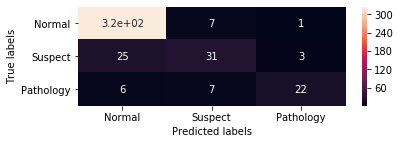

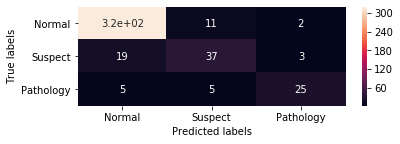

In [23]:
# Implement your code here:
mode = # choose a mode from the `nsd`
logreg_l2 = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000) # complete the arguments for L2
y_pred_2, w2 = pred_log(logreg_l2,) # complete this function using nsd function
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_2)
ax1 = plt.subplot(211)
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax1.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
logreg_l1 = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000) # complete the arguments for L1
y_pred_1, w1 = pred_log(logreg_l1,)  # complete this function using nsd function
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_1)
ax2 = plt.subplot(212)
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax2.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

Now that you are happy with your results, let's compare the coefficients of the two norms. Choose two weightning matrices (one calculated using $ L_2 $ and the other calculated using $ L_1 $) and use them as inputs in `w_all_tbl` function. This function sorts the weights according to their $ L_2 $ norm (so the first argument has to be the matrix of $ L_2 $) and compares them to $ L_1 $.

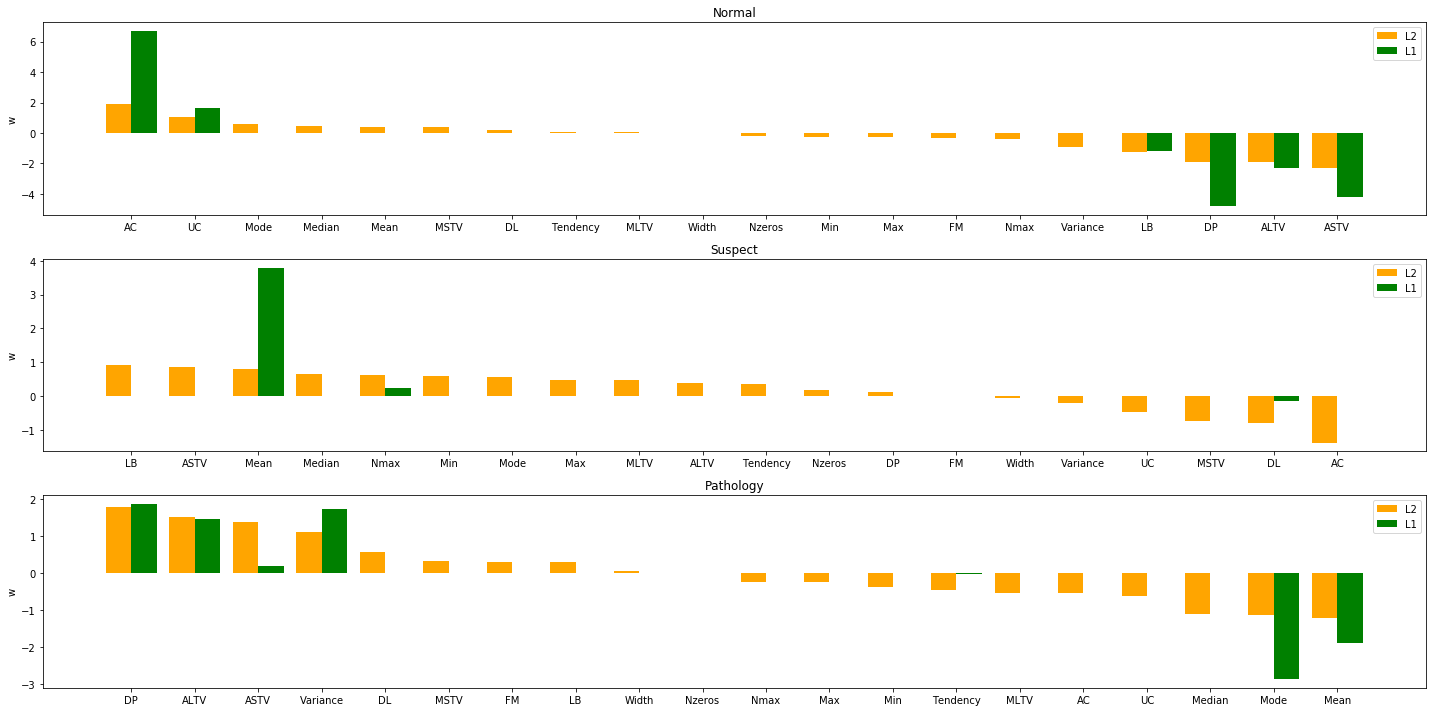

In [24]:
w_all_tbl(w2, w1, orig_feat)

Notice that the features are ordered differently because they are sorted according to $ L_2 $ values.

### Questions:
**Q9:** What is the difference that you can see when plotting $ L_1 $ vs. $ L_2 $? Could you expect it ahead?

**Q10:** Why is LASSO coupled with feature selection?

### Answers:
**Q9:**


**Q10:**

Now we will use a method that help us to choose what we call *hyperparameters* of the model. This is also a method of regularization and it is called **validation**. There are several types of validation and here we will use *stratified K-fold cross validation*. The hyperparmeters that we would like to choose are the norms that we want to train with and the regularization parameter. Again, we use stratification for the folds to prevent biased learning.

Implement the function `cv_kfold` in `lin_classifier` module. We will use `X_train` as our training set that will be iteratively divided into $ K-1 $ training sets and one validation set. **Notice:** choose wisely where to apply `norm_standard` function to avoid information leakage in every iteration. In this function you should build a list of dictionaries called `validation_dict` where each element in the list contains a dictionary with 4 keys name: `C, penalty, mu and sigma`. For every pair of parameters (`C and penalty`) you will run $ K $ validations and `mu and sigma` will be calculated as the average loss and standard deviation over $ K $ folds respectively. Use the function `log_loss` from `sklearn.metrics` that was already imported in `lin_classifier`. One more thing, you will have to implement a simple modification to `pred_log` function using the `flag` argument. When this flag is set to `True`, the function should return the probabilities of the classes and not the classes themselves. This is the output that `log_loss` function expects to get.

This function might take a while to perform depending on $ K $ and the number of regularization parameters you will choose.

In [25]:
C =  # make a list of up to 6 different values of regularization parameters and examine their effects
K =  # choose a number of folds
mode =  # mode of nsd function
val_dict = cv_kfold(X_train, y_train, C=C, penalty=['l1', 'l2'], K=K,mode=mode)

Let's visualize your results:

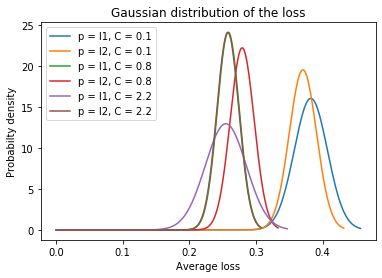

In [26]:
import scipy.stats as stats
for d in val_dict:
    x = np.linspace(0, d['mu'] + 3 * d['sigma'], 1000)
    plt.plot(x,stats.norm.pdf(x, d['mu'], d['sigma']), label="p = " + d['penalty'] + ", C = " + str(d['C'])) 
    plt.title('Gaussian distribution of the loss')
    plt.xlabel('Average loss')
    plt.ylabel('Probabilty density')
plt.legend()
plt.show()

You can now choose parameters according to the results and train you model with the **full training set**.

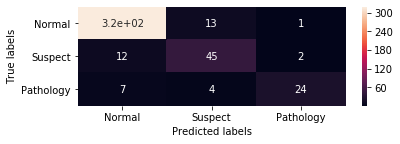

Accuracy is: 90.85%


In [27]:
C =  # complete this part according to your best result
penalty =  # complete this part according to your best result
logreg = LogisticRegression(solver='saga', multi_class='multinomial', penalty=penalty, C=C, max_iter=10000)
y_pred, w = pred_log(logreg,) # complete this function using nsd function
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax1 = plt.subplot(211)
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax1.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

Great job! So as you can see results did get better but not by that much but you got the feeling how to handle with data, what are the basics of learning and what are the real effects and applications of what you saw in the lectures. Now, one last thing: A possible reason for the poor improvements is that our data is probably not linearly separable and we used a linear classifier. There are two basic approaches for this kind of problem:
The first one is to use non-linear classifier and the second one is to perform a transformation on our data so it will become linearly separable in another space. Here is an example of 2D data that can also visualize the problem and the second approach:

<img src="https://sthalles.github.io/assets/fisher-ld/feature_transformation.png" width=600 align="center"> 

As you can see, the features were non-linearly transformed simply by squaring each feature.

### Questions:
**Q11:** Look at the data. Why was it reasonable to expect that squaring each feature would make the data linearly sperable?

**Q12:** Sugest another non-linear transformation that would make the data linealy seperable so that the line that seperates the two data types will be perpendicular to one of the new axes. Write the new two features (axes) **explicitly** as a funciton of $ (x_1,x_2) $. Use LaTex to write mathematical operations.

### Answers:
**Q11:** 


**Q12:**

Finally, just to get the feeling of better results when we go non-linear, let's try the random forest classifier. All you have to do is just choose one of the modes of the `nsd` function and see if you got better results:

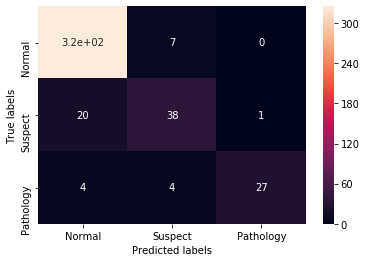

Accuracy is: 91.55%
F1 score is: 83.84%


In [28]:
from sklearn.ensemble import RandomForestClassifier as rfc
mode =  # choose your method
clf = rfc(n_estimators=10)
clf.fit(nsd(X_train, mode=mode), y_train)
y_pred = clf.predict(nsd(X_test, mode=mode))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal', 'Suspect', 'Pathology'],
            yticklabels=['Normal', 'Suspect', 'Pathology'])
ax.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

That's all folks!